Import modules, Load data, Set up network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import torchvision
import torchvision.transforms as transforms

#set up device to do it on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# load the data
transform = transforms.Compose(
    [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# torch.manual_seed(1)    # reproducible experiments

# set up the network
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

loss_func = torch.nn.CrossEntropyLoss()

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Train Network

0 , 0  loss: 2.4956750869750977
1 , 0  loss: 1.101623773574829
2 , 0  loss: 0.7912455201148987
3 , 0  loss: 0.44715699553489685
4 , 0  loss: 0.3904861807823181
5 , 0  loss: 0.32813435792922974
6 , 0  loss: 0.10320812463760376
7 , 0  loss: 0.1003778725862503
8 , 0  loss: 0.09367407113313675
9 , 0  loss: 0.0027566063217818737
10 , 0  loss: 0.0022574381437152624
11 , 0  loss: 0.0009196735918521881
12 , 0  loss: 0.0012182621285319328
13 , 0  loss: 0.0009990655817091465
14 , 0  loss: 0.0004837783344555646


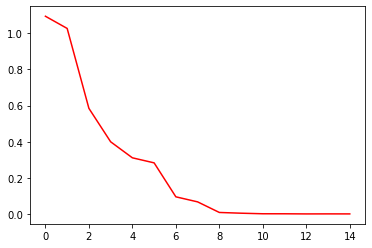

<Figure size 432x288 with 0 Axes>

In [2]:
Net18 = ResNet(BasicBlock, [2, 2, 2, 2])  # define the network
#print(Net18)  # net architecture

Net18 = Net18.to(device)

optimizer = torch.optim.SGD(Net18.parameters(), lr=0.02)

loss_values = []
for epoch in range(15):
    
    for i, data in enumerate(trainloader,0):
        
        x,y = data

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()  # clear gradients for next train
        
        out = Net18(x) 
        loss = loss_func(out, y)
        
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients
        # keep track of loss values for later plot
        
        if i % 500 == 0:    # print every 500 mini-batches
            print(epoch,',',i, ' loss:', loss.item())
            

    loss_values.append(loss.item())
#save the network
torch.save(Net18.state_dict(), 'ResNet18_15epochsGradDescent_params.pkl') 

#plot the loss
plt.plot(np.array(loss_values), 'r')
plt.show()

plt.savefig('ResNet18_15epochs_Loss.pdf')

Test Network

In [3]:
testNet = ResNet(BasicBlock, [2, 2, 2, 2])
testNet.load_state_dict(torch.load('ResNet18_15epochsGradDescent_params.pkl'))

total = 0
correct= 0

with torch.no_grad():
    for data in testloader:
        x, y = data
        # calculate outputs by running images through the network
        outputs = testNet(x)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()


accuracy = correct/total
print('Accurarcy:', accuracy)


Accurarcy: 0.7925
